In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
# Load and prepare data
data = pd.read_csv("../../data/cyclohexane.csv", header=0)

X = data.drop("solvent", axis=1)
best_sample = X.iloc[0].to_numpy().reshape(-1, 1)

In [3]:
plt.rcParams['font.size'] = 12

xticks = np.linspace(0, X.shape[1]-1, 6, dtype=int)
xlabels = X.columns[xticks].astype(float).astype(int).values

## Example Raw Spectra

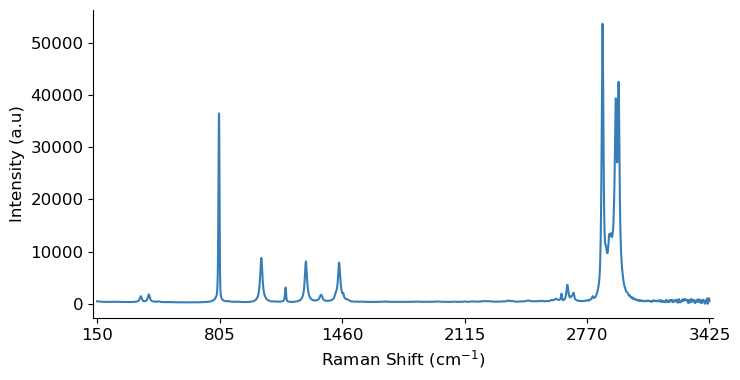

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.ylabel("Intensity (a.u)")
plt.xlabel("Raman Shift (cm$^{-1}$)")
plt.xlim([-20, 3296])
plt.xticks(xticks, labels=xlabels)
plt.grid(False)

plt.plot(best_sample, "#377eb8");

## Example Batch of Raw Spectra

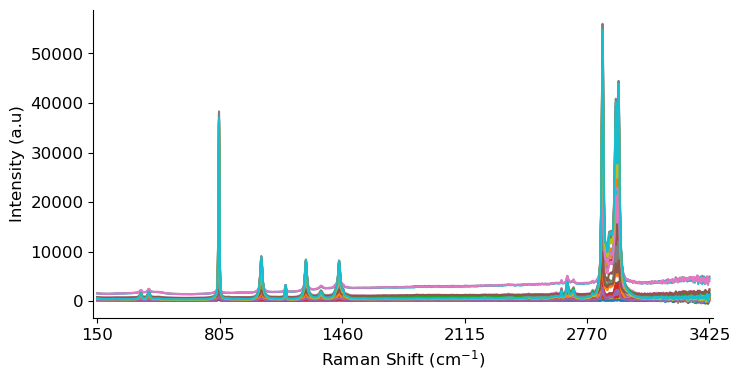

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.ylabel("Intensity (a.u)")
plt.xlabel("Raman Shift (cm$^{-1}$)")
plt.xlim([-20, 3296])
plt.xticks(xticks, labels=xlabels)
plt.grid(False)

plt.plot(X.iloc[:50, :].T); # semicolon to suppress matplotlib output, can also assign it as _ = plot(.)

## Additive and Multiplicative effects

In [6]:
additive_effect = best_sample + 2000 # constant baseline offset of 2000

# linear concentration reduction effect
mult_concentration_effect = best_sample * 0.8

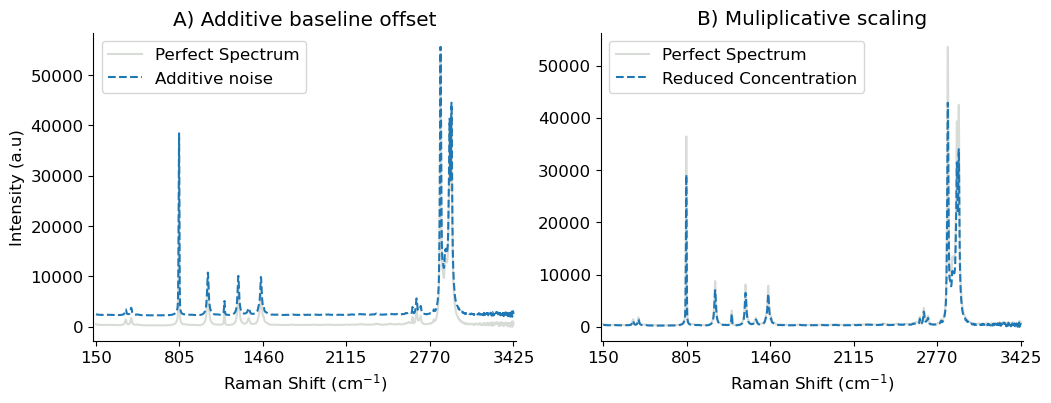

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_ylabel("Intensity (a.u)")

ax[0].set_title("A) Additive baseline offset")
ax[0].plot(best_sample, "#d8dcd6", label="Perfect Spectrum")
ax[0].plot(additive_effect, label="Additive noise", linestyle='--')

ax[1].set_title("B) Muliplicative scaling")
ax[1].plot(best_sample, "#d8dcd6", label="Perfect Spectrum")
ax[1].plot(mult_concentration_effect, label="Reduced Concentration", linestyle='--')

for i in range(2):
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')

    ax[i].set_xlabel("Raman Shift (cm$^{-1}$)")
    ax[i].set_xlim([-20, 3296])
    ax[i].set_xticks(xticks, labels=xlabels)

    ax[i].legend()

## Standard Normal Variate

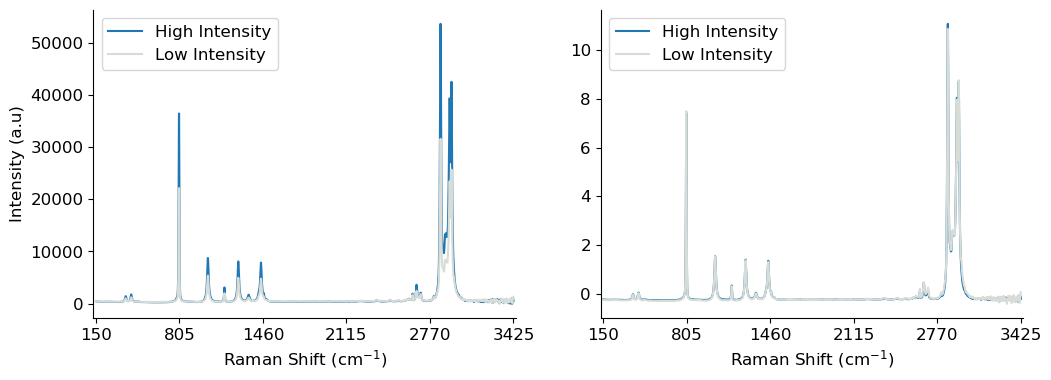

In [8]:
low_intensity_sample = X.iloc[3]

# z = (x - μ) / σ
snv_low_sample = (low_intensity_sample - np.mean(low_intensity_sample)) / np.std(low_intensity_sample)
snv_high_sample = (best_sample - np.mean(best_sample)) / np.std(best_sample)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_ylabel("Intensity (a.u)")

ax[0].plot(best_sample, label="High Intensity")
ax[0].plot(low_intensity_sample, "#d8dcd6", label="Low Intensity")

ax[1].plot(snv_high_sample, label="High Intensity")
ax[1].plot(snv_low_sample, "#d8dcd6",label="Low Intensity")

for i in range(2):
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')

    ax[i].set_xlabel("Raman Shift (cm$^{-1}$)")
    ax[i].set_xlim([-20, 3296])
    ax[i].set_xticks(xticks, labels=xlabels)

    ax[i].legend()

## Multiplicative Scatter Correction

In [9]:
def MSC(X, X_ref=None, mean_centre=True):
    """
    Perform Multiplicative Scatter Correction (MSC) on Raman spectral data.
    
    Parameters:
    X: np.ndarray 
        spectral (N x M) data matrix (n_samples, m_features).
    X_ref: np.ndarray 
        reference sample to fit data points too (1, m_features).
    mean_centre: bool 
        mean centre each sample before correction (default=False)

    Returns:
    X_corr: np.ndarray 
        corrected spectral data matrix.
    coefficients: np.ndarray 
        matrix of correction coefficients.
    """

    X_msc = X.to_numpy().copy()

    # mean centre correction
    if mean_centre:
        # Not required for MSC, but results in a smoother sample. Set mean_centre to False to test.
        X_msc -= np.mean(X_msc, axis=0)        

    if X_ref is None:    
        X_ref = np.mean(X_msc, axis=0)
    X_ref = X_ref.reshape(-1)

    # Initialise corrected spectra and coefficient arrays     
    X_corr = np.zeros_like(X_msc)
    coefficients = np.zeros((X_msc.shape[0], 2))
    
    for i, spectrum in enumerate(X_msc): # for each spectra
        # coefficient matrix to be solved by the least-squares (a @ x = b)
        A = np.vstack([X_ref, np.ones(X_msc.shape[1])]).T
    
        # Fit a least-squares of each sample to the reference spectra
        slope, intercept = np.linalg.lstsq(A, spectrum, rcond=None)[0]

        coefficients[i, :] = slope, intercept

        # correct the spectrum (xi - ai) / bi
        X_corr[i] = (spectrum - intercept) / slope
 
    return X_corr, coefficients

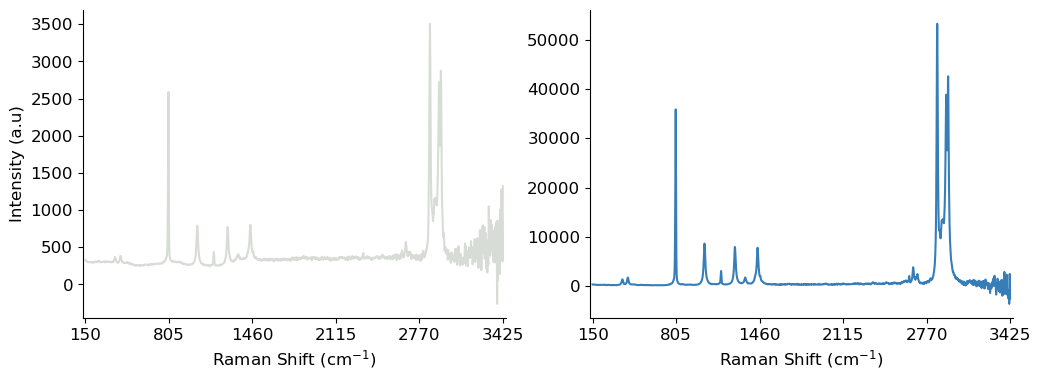

In [10]:
idx = 4
sloping_sample = X.iloc[idx]
msc_corrected_spectra, _ = MSC(X, X_ref=best_sample, mean_centre=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_ylabel("Intensity (a.u)")

ax[0].plot(sloping_sample, "#d8dcd6");
ax[1].plot(msc_corrected_spectra[idx], "#377eb8")

for i in range(2):
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')

    ax[i].set_xlabel("Raman Shift (cm$^{-1}$)")
    ax[i].set_xlim([-20, 3296])
    ax[i].set_xticks(xticks, labels=xlabels)

## Extended Multiplicative Scatter Correction

EMSC seems to be not appropriate for this data. The compound only presents with linear baseline offsets, so modelling for higher-order distortions tends to be a disadvantage here.

In [11]:
def EMSC(X, X_ref=None, mean_centre=True, degree=2, wavelengths=None):
    """
    Perform Extended Multiplicative Scatter Correction (EMSC) on Raman spectral data.
    
    Parameters:
    X: np.ndarray 
        spectral (N x M) data matrix (n_samples, m_features).
    X_ref: np.ndarray 
        reference sample to fit data points to (1, m_features). If None, mean spectrum is used.
    mean_centre: bool 
        mean centre each sample before correction
    degree, int 
        order of polynomial to fit
    wavelengths: np.ndarray 
        array of wavelengths corresponding to spectral features (default=None). If None, a sequential range is used.
    
    Returns:
    X_corr: np.ndarray, 
        corrected spectral data matrix.
    coefficients: np.ndarray, 
        matrix of correction coefficients.
    """
   
    X_emsc = X.to_numpy().copy()
    
    # mean centre correction
    if mean_centre:
        # Not required for EMSC, but results in a smoother sample. Set mean_centre to False to test.
        X_emsc -= np.mean(X_emsc, axis=0)     

    # Handle reference spectrum
    if X_ref is None:
        X_ref = np.mean(X_emsc, axis=0)

    X_ref = X_ref.flatten()

    # Handle wavelengths
    if wavelengths is None:
        wavelengths = np.arange(X_emsc.shape[1])
    elif wavelengths.shape[0] != X_emsc.shape[1]:
        raise ValueError("Wavelength array must have the same length as the number of features.")

    # Initialise corrected spectra and coefficient arrays 
    X_corr = np.zeros_like(X_emsc)
    coefficients = np.zeros((X_emsc.shape[0], degree + 2))

    # Construct polynomial column vectors (x, x^2, ..., x^degree)
    if degree > 0:
        P = np.vstack([wavelengths**d for d in range(1, degree + 1)]).T
    else:
        P = np.empty((len(wavelengths), 0))  # empty baseline term

    # Create extended matrix (constant + reference spectrum + polynomial terms)
    M = np.column_stack((np.ones_like(X_ref), X_ref, P))

    for i, spectrum in enumerate(X_emsc): # for each spectra
        
        # Solve least squares problem: M * x = coefficients
        coeffs = np.linalg.lstsq(M, spectrum, rcond=None)[0]
        # coeffs[0] = additive offset (a_i)
        # coeffs[1] = multiplicative scaling factor (b)
        # coeffs[2:] = polynomial baseline coefficients
        
        # Store coefficients
        coefficients[i] = coeffs

        # Handle potential division errors
        if coeffs[1] == 0:
            raise ValueError(f"Multiplicative factor (coeffs[1]) is zero for spectrum {i}, normalisation failed.")

        # Apply correction
        # xi - ai - dot(polynomial trends, polynomial baseline coefficients)
        sub_baseline = spectrum - coeffs[0] - P.dot(coeffs[2:]) # subtract baseline
        X_corr[i] = sub_baseline / coeffs[1] # normalise on reference spectra (b)

    return X_corr, coefficients

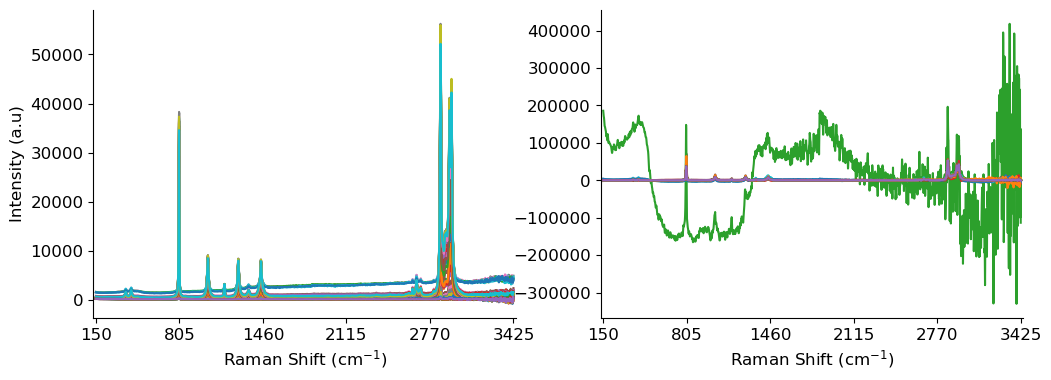

In [12]:
# testing both the degree and mean centring tends to have little effect. This method is just not appropriate for this data.
emsc_corrected_spectra, _ = EMSC(X, X_ref=best_sample, degree=2, mean_centre=True, wavelengths=X.columns.astype(float).astype(int).values)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_ylabel("Intensity (a.u)")

ax[0].plot(X.T);
ax[1].plot(emsc_corrected_spectra.T)

for i in range(2):
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')

    ax[i].set_xlabel("Raman Shift (cm$^{-1}$)")
    ax[i].set_xlim([-20, 3296])
    ax[i].set_xticks(xticks, labels=xlabels)

## Orthogonal Signal Correction

A simplified OSC algorithm based on the original work by Wold et al.

*Wold, S.; Antti, H.; Lindgren, F.; Öhman, J. Orthogonal signal correction of near-
infrared spectra. Chemometrics and Intelligent laboratory systems 1998, 44, 175–185*

Section 3. Filtering and calibration onwards

In [13]:
def OSC(X, y, n_components=1, transform=False, pls_components=1):
    """
    Perform Orthogonal Signal Correction (OSC) using Partial Least Squares (PLS) regression
    
    Parameters:
        X: np.ndarray
            Spectral data matrix (n_samples, n_features).
        y: np.ndarray
            Response variable (n_samples, ).
        n_components: int
            Number of orthogonal components to remove (default=1).
        transform: bool
            Optional method to scale or mean centre the data (default=False).
        pls_components: int
            Number of components to apply in PLS regression (default=1).
        
    Returns:
        X_corr: np.ndarray
            The corrected spectral data matrix with the same shape as X.

    Key steps:
        1. Optional: Scale or transform data 
        2. Fit a PCA/PLS-like regression to explain y using X and identify the components of X related to y.
        3. Extract scores residuals
        4. Project X and compute orthogonal part of X to y
        5. Remove the components from X orthogonal to y and apply residuals matrix X' for next component
    """
    
    X_corr = X.to_numpy().copy()
    y_corr = y.copy()

    # Step 1: Optionally transform data
    if transform:
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        
        # Scale
        X_corr = scaler_X.fit_transform(X_corr)
        y_corr = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()
        
        # or mean centre for example
        # X_corr -= np.mean(X_corr, axis=0)  

    # for each component
    for _ in range(n_components):
        
        # Step 2: Fit PLS model to find components predictive of y
        pls = PLSRegression(n_components=2)
        pls.fit(X_corr, y_corr)
        
        # Step 3: Extract the scores and loadings (latent variables) of X
        t = pls.x_scores_ # orthogonal vector t
        p = pls.x_loadings_ #  loading vector p
    
        # Orthogonal part of X
        # 'residual matrix is then calculated by removing from X the orthogonalized scores (t) times the final loadings (p)'
        X_pred = np.matmul(t, np.transpose(p))
    
        # Step 5: Correct the data by removing the orthogonal part
        X_corr = X_corr - X_pred

    if transform:
        # Inverse standardization
        X_corr = scaler_X.inverse_transform(X_corr)

    # 'The final residual matrix E_A'
    return X_corr, t, p

In [14]:
# Simulated concentration data
y = np.random.rand(X.shape[0])

# Perform OSC
X_osc, t, p = OSC(X, y, n_components=1, transform=True, pls_components=3)

print("Original X shape:", X.shape)
print("Corrected X shape:", X_osc.shape)
print("Scores (T) shape:", t.shape)
print("Loadings (P) shape:", p.shape)

print()

# Before applying OSC, let's print the covariance to check the correlation
print("Covariance between X and y before OSC:", np.corrcoef(X.T, y)[-1, :-1])

# After applying OSC, check the covariance again
print("Covariance between X and y after OSC:", np.corrcoef(X_osc.T, y)[-1, :-1])

Original X shape: (145, 3276)
Corrected X shape: (145, 3276)
Scores (T) shape: (145, 2)
Loadings (P) shape: (3276, 2)

Covariance between X and y before OSC: [0.08765214 0.08892726 0.08994247 ... 0.09612713 0.10550277 0.09626211]
Covariance between X and y after OSC: [ 0.03446062  0.04442973  0.04902023 ... -0.00978281  0.01418998
 -0.02815665]
